In [197]:
# df.resample('M').mean()

# Data Dictionary

|Feature|Type|Description|
|---|---|---|
|Product_Code|*string*|The product name encoded|
|Warehouse|*string*|Warehouse ID|
|Product_Category|*string*|Product category of each product|
|Date|*string*|The date customer needs the product|
|Order_Demand|*string*|Order quantity|

In [198]:
# Import libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.metrics import RSquare
from tensorflow.keras.callbacks import EarlyStopping

In [199]:
# Read csv file and display shape.
df = pd.read_csv('../Data_Historical/df2.csv').iloc[:,1:]
df.shape

(924272, 5)

In [200]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,Whse_A,Category_006,2011-01-08,2
1,Product_1724,Whse_A,Category_003,2011-05-31,108
2,Product_1521,Whse_S,Category_019,2011-06-24,85000
3,Product_1521,Whse_S,Category_019,2011-06-24,7000
4,Product_1507,Whse_C,Category_019,2011-09-02,1250


df_init = df[df['Product_Code']==code]
    df_init['Date'] = pd.to_datetime(df_init['Date'])
    df_init = df_init.set_index('Date')
    df_init = pd.DataFrame((df_init['Order_Demand']).resample('W').sum())
    df_init.rename(columns={'Order_Demand':code},inplace=True)
    all_cat_019 = pd.concat([all_cat_019,df_init],axis=1)

In [201]:
tf.random.set_seed(7)

In [202]:
# Queries all rows of Product 1359.
df_1359 = df[df['Product_Code']=='Product_1359']

# Convert Date to datetime format.
df_1359['Date'] = pd.to_datetime(df_1359['Date'])

# Set Date as index.
df_1359 = df_1359.set_index('Date')

# Resample Order Demand of Product 1359 to weekly sales in the multiple of 1000.
prod_1359 = pd.DataFrame((df_1359['Order_Demand']/1000).resample('W').sum())
prod_1359.rename(columns={'Order_Demand':'demand'}, inplace=True)

C:\Users\Zeonice\AppData\Local\Temp\ipykernel_14980\1070879320.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1359['Date'] = pd.to_datetime(df_1359['Date'])


In [203]:
# split a univariate sequence
def split_sequence(sequence, n_steps):
 X, y = list(), list()
 for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
        break
    
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
 return array(X), array(y)

In [213]:
# define input sequence
raw_seq = prod_1359['demand']

# choose a number of time steps
n_steps = 4

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [214]:
X_train = X[0:207]
X_test = X[207:]
y_train = y[0:207]
y_test = y[207:]

In [206]:
prod_1359['demand'].iloc[258:262]

Date
2016-12-18    1319.0
2016-12-25    1006.0
2017-01-01     403.0
2017-01-08     100.0
Freq: W-SUN, Name: demand, dtype: float64

In [250]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=.0005), loss='mse', metrics=['mape'])

es = EarlyStopping(patience = 30)
# fit model
lstm = model.fit(X_train, y_train, epochs=300, verbose=0, validation_data=(X_test, y_test), callbacks = [es])

In [251]:
lala =pd.DataFrame(lstm.history)
lala

,loss,mape,val_loss,val_mape
0,2.705388e+06,180.658173,2.050350e+06,95.745995
1,2.558977e+06,193.315353,1.940129e+06,91.952629
2,2.447329e+06,179.834961,1.827230e+06,88.266968
3,2.281094e+06,223.192810,1.654495e+06,79.989967
4,2.105788e+06,390.726746,1.511555e+06,75.181175
...,...,...,...,...
56,5.583057e+05,2716.936523,4.364647e+05,67.981171
57,5.158914e+05,2363.171143,4.376738e+05,61.810509
58,5.030589e+05,2277.526367,4.281664e+05,61.901005
59,5.019052e+05,2208.399414,4.095113e+05,63.126667


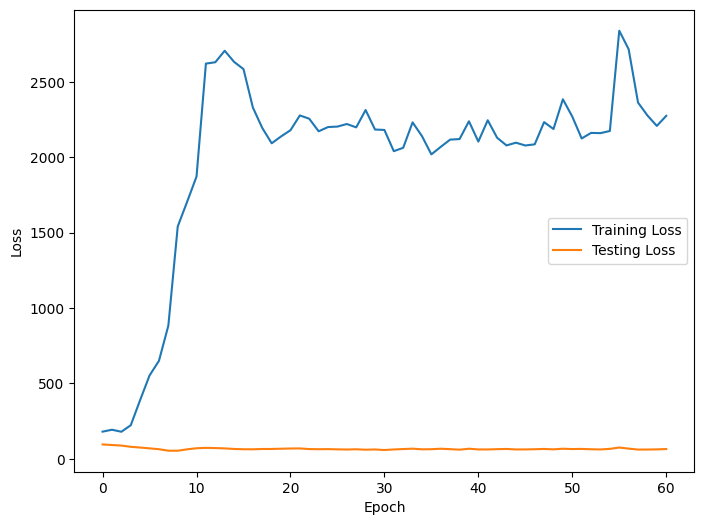

In [252]:
# Check out our train loss and test loss over epochs.
train_loss = lstm.history['mape']
test_loss = lstm.history['val_mape']

# Set figure size.
plt.figure(figsize=(8, 6))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')

# Set title
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend();

In [186]:
y[258]

100.0

In [189]:
prod_1359['demand'].iloc[261]

100.0

In [242]:
# demonstrate prediction
x_input, ynull = split_sequence(prod_1359['demand'].iloc[254:262],n_steps)
x_input = x_input.reshape((x_input.shape[0], x_input.shape[1], n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[1217.2734]
 [1114.6342]
 [1175.1094]
 [1016.1787]]


In [226]:
x_input

array([[[1290.],
        [ 902.],
        [1439.],
        [1190.]],

       [[ 902.],
        [1439.],
        [1190.],
        [1319.]],

       [[1439.],
        [1190.],
        [1319.],
        [1006.]],

       [[1190.],
        [1319.],
        [1006.],
        [ 403.]]])

In [220]:
y_test

array([1593., 1878., 1711., 1480., 1160.,  992., 2317., 1135., 2031.,
        880.,  879., 2378., 1008.,  797.,  832.,  338., 2008.,  723.,
       1891., 1352., 2595., 1224., 1425., 1753., 1987.,  811., 1244.,
       1239., 1705.,  389., 1326., 2059., 1300., 1343., 1233.,  813.,
       1795., 1005., 2803., 1368.,  900., 2117., 2219., 1290.,  902.,
       1439., 1190., 1319., 1006.,  403.,  100.])

In [81]:
 # evaluate the model
 scores = model.evaluate(X, y, verbose=0)

In [82]:
scores

505059.28125

In [86]:
model.metrics_names, scores

(['loss'], 505059.28125)

# GRU

In [79]:
# define model GRU
model_gru = Sequential()
model_gru.add(GRU(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model_gru.add(GRU(50, activation='relu'))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mse')
# fit model
model_gru.fit(X, y, epochs=300, verbose=0)

In [80]:
# demonstrate prediction
x_input, ynull = split_sequence(prod_1359['demand'].iloc[254:262],n_steps)
x_input = x_input.reshape((x_input.shape[0], x_input.shape[1], n_features))
yhat_gru = model_gru.predict(x_input, verbose=0)
print(yhat_gru)

[[1087.1621 ]
 [1114.6328 ]
 [1156.3435 ]
 [1003.5247 ]
 [ 753.49084]]
